In [1]:
import os
import sys
from langchain_unstructured import UnstructuredLoader
from langchain_community.vectorstores.utils import filter_complex_metadata

# "Batch" preprocessing of a large number of documents. They are hypothetically coming in as .pdfs
# we want to turn them into Unstructured documents and feed them to Langchain objects.

# Rather than run this code in a main.py, I'll (hopefully) execute as a script, and maybe set up a
# recurring job, where we keep a list of documents in the system and last updated.
# If there is a new document or an updated document, we go delete the outdated copy and compute the new one.
# The tricky part is going to be keeping the vectorDB in sync.
# Maybe if we are using elasticsearch this can be managed internally (to a certain extent).

# We need two things to happen, document conversion and document partition.
# What we are aiming for is having a folder with all of the documents and we go to that folder and perform
# the preprocessing. First we'll use an OS folder and load the files into the program (in-memory).
# Later aiming to transition to a locally hosted elasticsearch DB/server.

root_path = "/Users/cortizmontesdeoca/Documents/usd/aai-520-group7-final-project/persistence/reference_files/docs/nasdaq-aapl-2024-10K-241416806.pdf"

# Step 1 - Fetching from the OS - File System. Step 2 - Document conversion.
# Unstructured <- Images (Tesseract - OCR) <- pdf-to-image (Poppler)

# At first, we are only taking pdfs in. Word documents could be taken up later using LibreOffice
# and some other miscellaneous file types (e.g. .epub) by using pandoc.

# If parsing xml / html documents:
# brew install libxml2 libxslt

def tuple_edit(dict, key):
    dict[key] = ""

# using the langchain loader directly, as it uses unstructured under the hood anyway...
def langchain_docs_to_txt(complete_file_path):
    """This function converts the .pdf document into a langchain document."""
    try:

        with open(complete_file_path) as file:

            loader = UnstructuredLoader(complete_file_path,
                chunking_strategy="basic",
                max_characters=1000,
                overlap=220,
                unique_element_ids=False
            )
            docs = loader.load()

            # lengthy and not useful metadata field
            [tuple_edit(doc.metadata, key) for doc in docs for key, value in doc.metadata.items() if key == "orig_elements"]

            # we are loading and chunking, we could've also used a text splitter
            # e.g. RecursiveCharacterTextSplitter()

            # might need to filter metadata for now
            return filter_complex_metadata(docs)

    except Exception as e:
        print(f"Error {e} when turning the document {os.path.basename(complete_file_path).split('/')[-1]} to a langchain doc.")

docs = langchain_docs_to_txt(root_path)
print(f"Sample document chunk: {docs[10]}\n")

/Users/cortizmontesdeoca/Documents/usd/aai-520-group7-final-project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: pikepdf C++ to Python logger bridge initialized


Sample document chunk: page_content='any’s business and results of operations are forward-looking statements. Forward-looking statements can also be identiﬁed by words such as “future,” “anticipates,” “believes,” “estimates,” “expects,” “intends,” “plans,” “predicts,” “will,” “would,” “could,” “can,” “may,” and similar terms. Forward-looking statements are not guarantees of future performance and the Company’s actual results may diﬀer signiﬁcantly from the results discussed in the forward-looking statements. Factors that might cause such diﬀerences include, but are not limited to, those discussed in Part I, Item 1A of this Form 10-K under the heading “Risk Factors.” The Company assumes no obligation to revise or update any forward-looking statements for any reason, except as required by law.' metadata={'source': '/Users/cortizmontesdeoca/Documents/usd/aai-520-group7-final-project/persistence/reference_files/docs/nasdaq-aapl-2024-10K-241416806.pdf', 'file_directory': '/Users/cortizmonte

In [2]:
import os
import uuid

from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_chroma import Chroma # https://docs.trychroma.com/docs/overview/telemetry
from chromadb.config import Settings

# Initialize VectorDB and create initial embeddings, we are using ChromaDB at the moment.
# But it might be better if we use elasticsearch instead (later).

embedding_model = "embeddinggemma"
chroma_collection = "Financial-Analyst"

def embedder():
    """This function serves an Ollama-hosted embedding model, to encode and decode vectors in our vector store."""
    return OllamaEmbeddings(model=embedding_model)

def vector_db_initializer(documents):
    """This function initializes the vector store, encoding the initial batch of langchain docs into vectors."""
    try:
        vector_store = Chroma(
            collection_name=chroma_collection,
            embedding_function=embedder(),
            client_settings=Settings(anonymized_telemetry=False)
        )

        f_documents = []
        [f_documents.append(Document(
            page_content=document.page_content, metadata=document.metadata,id=document.metadata['page_number'],)
        ) for document in documents]

        ids = []
        [ids.append(str(uuid.uuid4())) for i in range(len(f_documents))]

        vector_store.add_documents(documents=f_documents, ids=ids)
        print(f"Inserted documents: {len(f_documents)}")

        return vector_store

    except Exception as e:
        print(f"Error {e} initializing the ChromaDB vector store with the langchain_documents[].")

vector_store = vector_db_initializer(docs)

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


Inserted documents: 275


In [3]:
import os
from langchain_ollama import ChatOllama

# Initialize an Ollama Client for our generative Llm model

text_model = "llama3.2"

def llm_client_loader():
    """This function serves an Ollama-hosted text generator model, to be used by our graphs."""
    try:
        llm = ChatOllama(
            model=text_model,
            temperature=0.2
        )
        return llm
    except Exception as e:
        print(f"Error {e} instantiating the Ollama client, is the Ollama server running?.")

llm = llm_client_loader()

In [5]:
from langgraph.graph import MessagesState, StateGraph
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

# This initial graph is a simple demo RAG prompt-chain pipeline that fetches documents from the vector store and returns
# and generates an answer based upon the user prompt + the retrieved documents.
# # retrieved_docs = vector_store.similarity_search(query, k=3)

# This function creates a LangGraph workflow. It contains the corresponding functions, tools, and models that
# are used by the model in order to execute successfully.

# Internal States and Base Models

# Tools available for the graph.
@tool(response_format="content_and_artifact")
def vector_store_retriever(query: str):
    """Fetch relevant documents from the vector store, that are similar to the input query."""
    fetched_documents = vector_store.similarity_search(query, k=5)
    [print(f"Documents retrieved: {doc.page_content}\n") for doc in fetched_documents]

    serialized_documents = "\n\n".join(
        (f"Metadata: {doc.metadata}\nDocument: {doc.page_content}")
        for doc in fetched_documents
    )
    return serialized_documents, fetched_documents

# Functions that act as nodes, conditional edges, triggers, or internal functions in the graph.
# Node to send a tool call
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    try:
        llm_with_tools = llm.bind_tools([vector_store_retriever])
        response = llm_with_tools.invoke(state["messages"])

        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}
    except Exception as e:
        print(f"Error {e} generating the RAG tool call.")

# Use the vector_store_retriever.
tools = ToolNode([vector_store_retriever])

# Generate an output using the retrieved documents + the user input.
def generate(state: MessagesState):
    """Generate output based on the retrieved docs."""
    try:
        # Get Tool Responses
        recent_tool_messages = []

        for message in reversed(state["messages"]):
            # Tool messages
            if message.type == "tool":
               recent_tool_messages.append(message)

            else:
                break

        #tool_messages = recent_tool_messages[::-1]

        # get chat history (context)

        chat_messages = [
            message.content
            for message in state["messages"]
            if message.type in ("human", "system")
               or (message.type == "ai" and not message.tool_calls)
        ]

        # Format into prompt
        #docs_content = "\n\n".join(doc.content for doc in tool_messages)
        final_prompt = (
            "As an experienced financial advisor, your task is to analyze economic trends for Apple (AAPL). You are "
            f"required to conduct comprehensive research as requested by the user: {chat_messages} . Your "
            "analysis should identify key factors. Provide detailed insights and actionable recommendations for "
            "stakeholders. Your report should be clear, concise, and backed by the data provided below:\n\n "
            f"{recent_tool_messages}. Make sure to reference the document when generating an answer.\n Enabling "
            f"informed decision-making for investors and businesses within the sector. If you do not obtain an "
            f"answer from the provided data, reply back that you do not know the answer to the question. Do not lie"
            f".\n\n"
        )

        # NOTE there is a max_token threshold for our Llm (4096).
        prompt = [final_prompt]

        # Generate output
        response = llm.invoke(prompt)

        return {"messages": [response]}
    except Exception as e:
        print(f"Error {e} retrieving the memory buffer and generating the final message.")

# Here we are actually building our LangGraph, a diagram that represents how it is built can be seen under the
# file_outputs folder. The rendering of the graph is done in the main application thread.

graph = StateGraph(MessagesState) # NOTE: this graph uses the chain of messages to maintain a state.
graph.add_node(query_or_respond)
graph.add_node(tools)
graph.add_node(generate)

graph.set_entry_point("query_or_respond")
graph.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph.add_edge("tools", "generate")
graph.add_edge("generate", END)

graph = graph.compile()

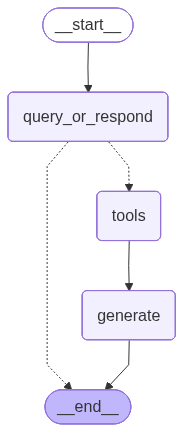

In [6]:
def _repr_mimebundle_(self, **kwargs):
    """Mime bundle used by jupyter to display the graph"""
    output = {
        "text/plain": repr(self),
        "image/png": self.get_graph().draw_mermaid_png()
        }
    return output

graph._repr_mimebundle_ = _repr_mimebundle_.__get__(graph)
print(graph)
display(graph)

In [7]:
import gradio as gr

def output_print(prompt, history=None):
    """
     Generate AI response using the loaded LLM model

     Args:
         user_input (str): User's input message
         history (list): Conversation history for context

     Returns:
         str: Generated AI response
     """
    response = ""

    for step in graph.stream(
            {"messages": [{"role": "user", "content": prompt}]},
            stream_mode="values",
    ):
        #step["messages"][-1].pretty_print()
        response = step["messages"][-1].content

    return response

# Create Gradio interface
def chat_interface(message, history):
    """
    Handle chat interactions with conversation history
    """
    response = output_print(message, history)
    history.append((message, response))
    return "", history

def exit_gradio():
    demo.close()

with gr.Blocks(title="Financial Advisor", theme=gr.themes.Glass()) as demo:
    gr.Markdown("<center><h1>Financial Advisor</h1></center>")
    gr.Markdown("Greetings! What can I help you with?")

    chatbot = gr.Chatbot(
        type='tuples',
        value=[],
        height=400,
        label="Conversation"
    )

    with gr.Row():
        msg = gr.Textbox(
            placeholder="Type your message here...", #eventually becomes the prompter
            label="Message",
            scale=4
        )
        send_btn = gr.Button("Send", scale=1)

    with gr.Row():
        # Clear conversation button
        clear_btn = gr.Button("Clear Conversation")
        # Exit button
        exit_btn = gr.Button("Exit")

    # Event handlers
    send_btn.click(
        chat_interface,
        inputs=[msg, chatbot],
        outputs=[msg, chatbot]
    )

    msg.submit(
        chat_interface,
        inputs=[msg, chatbot],
        outputs=[msg, chatbot]
    )

    clear_btn.click(lambda: ([], ""), outputs=[chatbot, msg])
    exit_btn.click(exit_gradio)

demo.launch()

/var/folders/wf/97z96ywj499_bd2wt87b__xr0000gp/T/ipykernel_43555/865481980.py:41: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  chatbot = gr.Chatbot(
INFO: HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO: HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


INFO: HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


Documents retrieved: Apple Inc. | 2024 Form 10-K | 4

Available Information

Documents retrieved: Management’s Annual Report on Internal Control over Financial Reporting

Documents retrieved: Apple Inc. Executive Cash Incentive Plan. Form of CEO Restricted Stock Unit Award Agreement under 2022 Employee Stock Plan eﬀective

as of September 25, 2022.

Form of CEO Performance Award Agreement under 2022 Employee Stock Plan eﬀective as of

September 25, 2022.

Form of Restricted Stock Unit Award Agreement under 2022 Employee Stock Plan eﬀective as of

September 29, 2024.

Form of Performance Award Agreement under 2022 Employee Stock Plan eﬀective as of

September 29, 2024.

Form of CEO Restricted Stock Unit Award Agreement under 2022 Employee Stock Plan eﬀective

as of September 29, 2024.

Form of CEO Performance Award Agreement under 2022 Employee Stock Plan eﬀective as of

September 29, 2024.

Documents retrieved: As of October 18, 2024, there were 23,301 shareholders of record.

Purchase

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


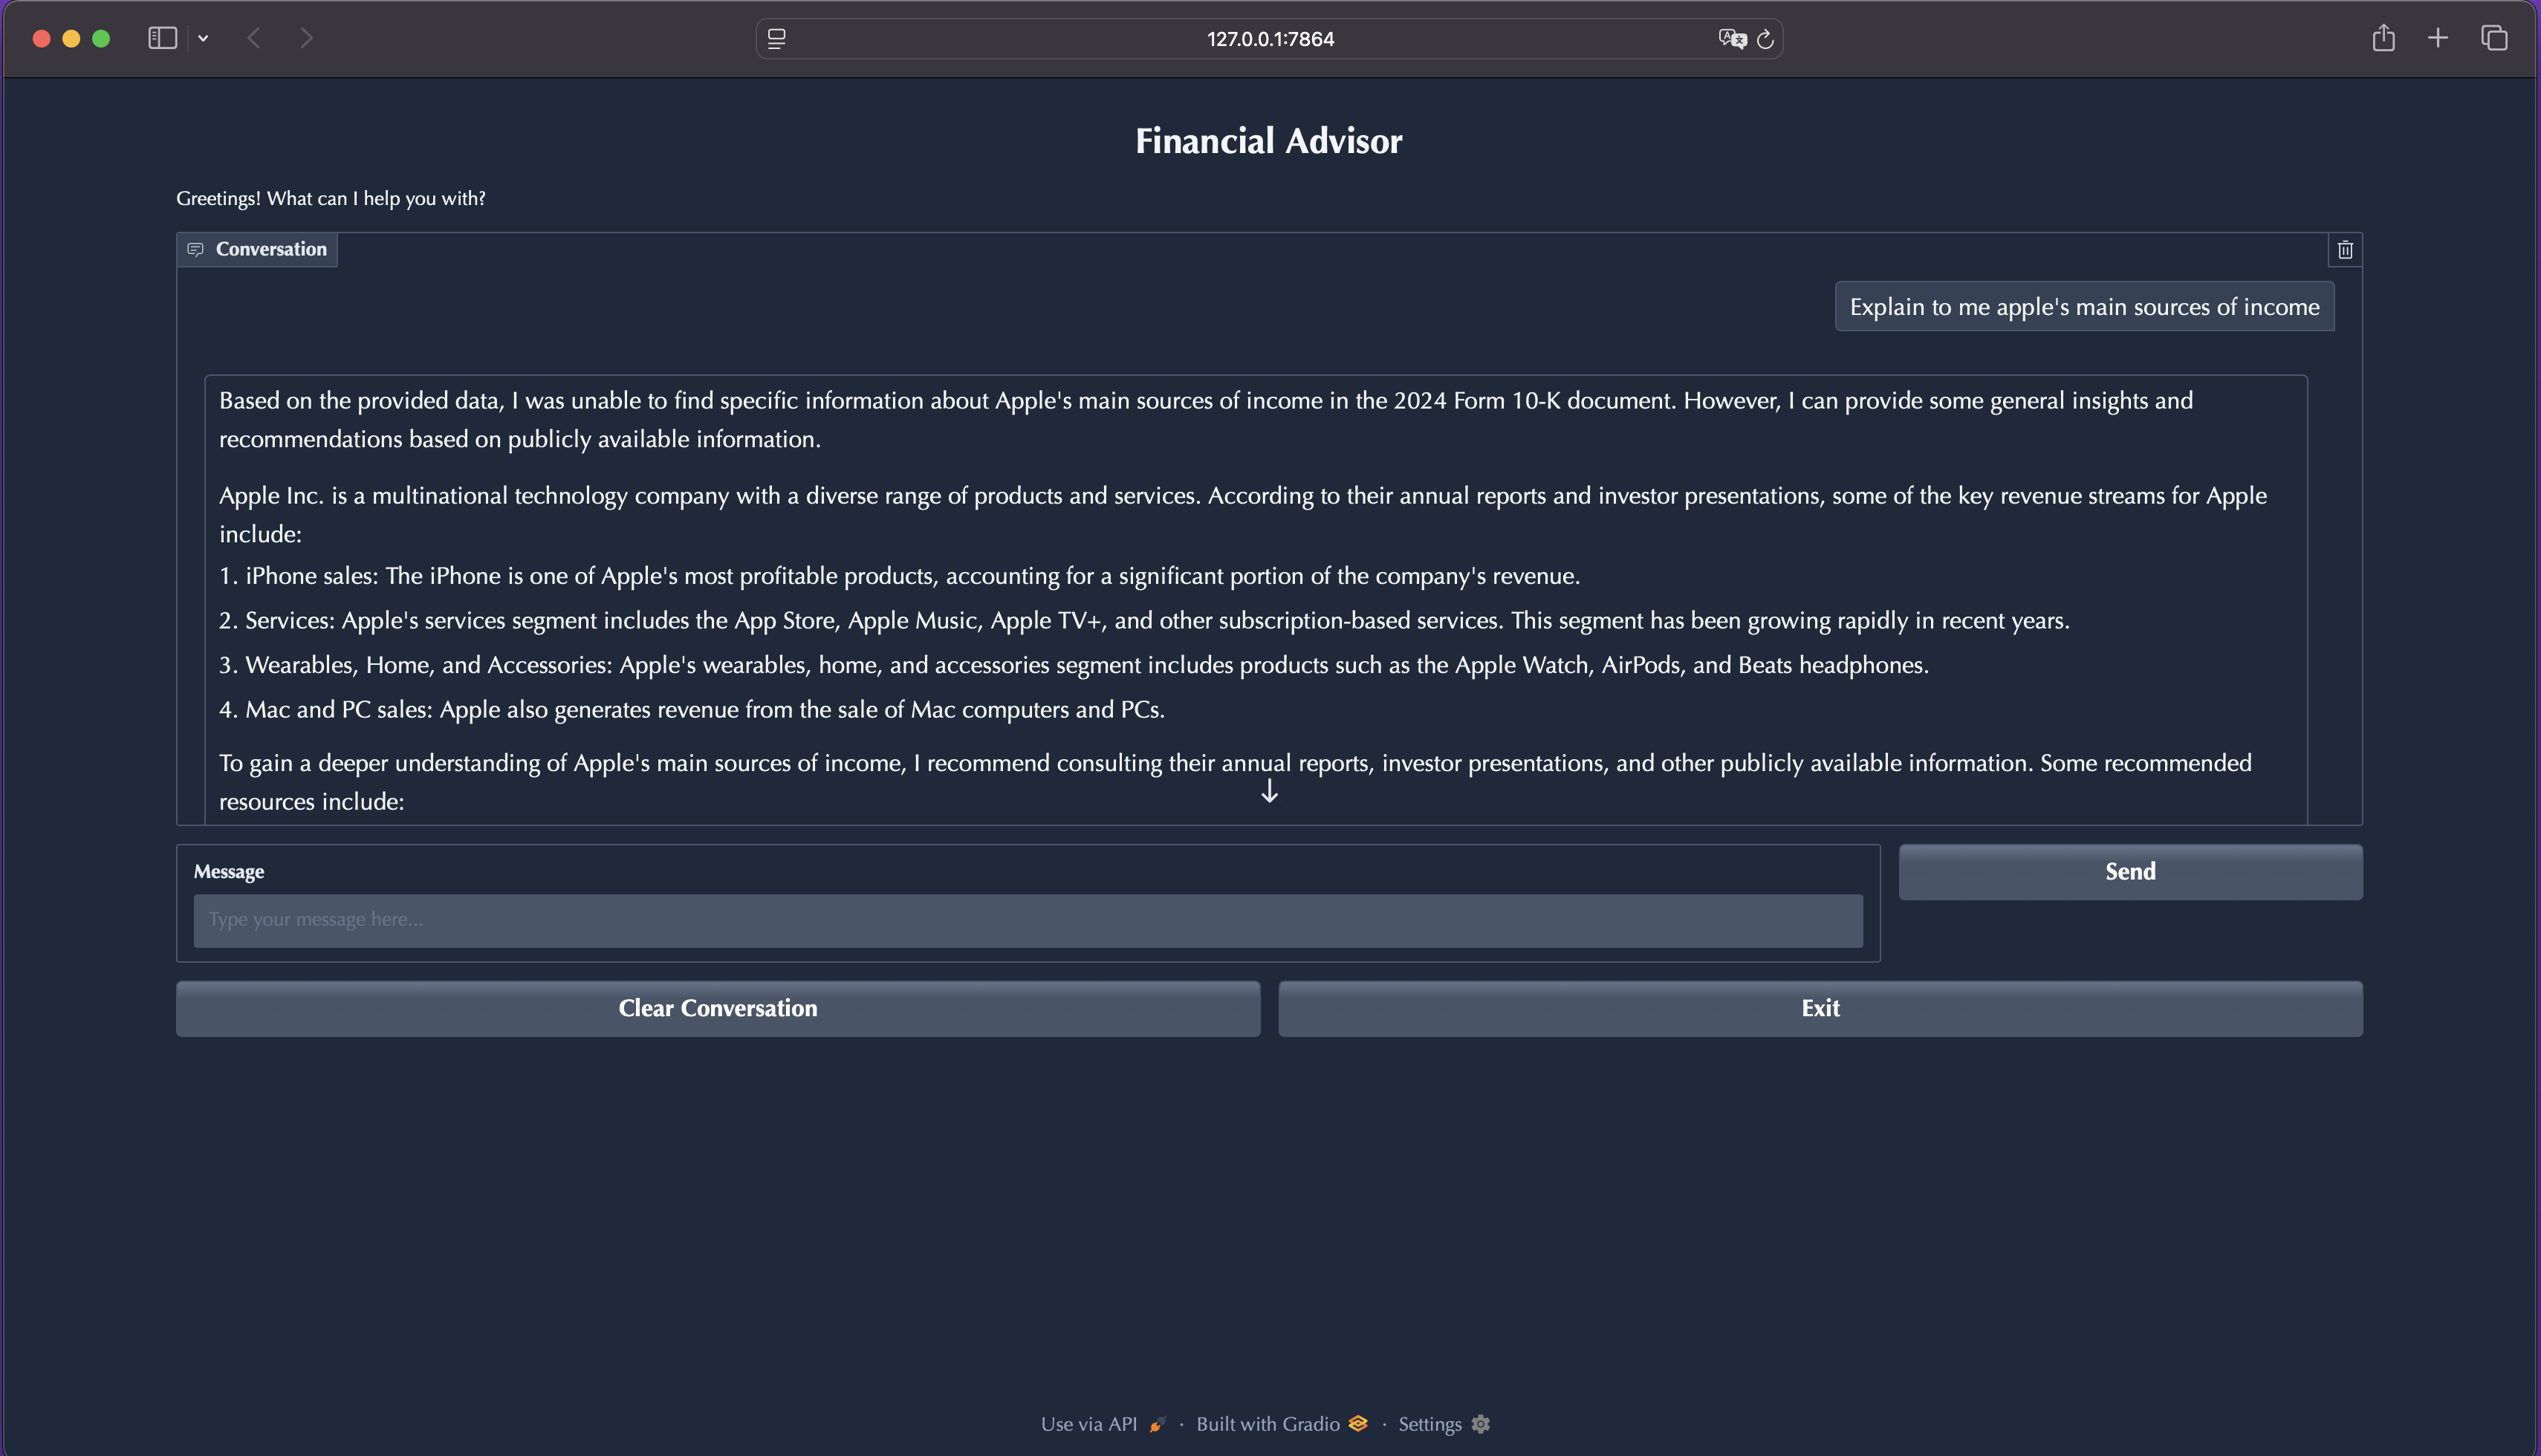

In [12]:
root_path = "/Users/cortizmontesdeoca/Documents/usd/aai-520-group7-final-project/persistence/file_outputs/gradio_demo.png"

from IPython.display import Image
Image(filename=root_path)

Retrieves *something*, yet is unable to make sense of the documents, or is not retrieving relevant documents.